In [1]:
import pandas as pd
import numpy as np
import cython
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from CalculateMetrics import calculate_all_metrics

df = pd.read_csv("C:/Users/iwama/Desktop/Osobiste/MSc/put-msc/Endometriosis/endometriosis.csv")
X = df.drop(columns=['target'])
y = df['target'].astype('int')
# # Split the data into training and testing sets
# X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.4, random_state=42, stratify=y_test_val)

# holdout + CV
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
print(f"Train/Val size: {len(y_trainval)}, Test size: {len(y_test)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Train/Val size: 742, Test size: 132
Class distribution in test set: [109  23]


In [2]:
def run_test(model, name, X_train, y_train, X_test, y_test):
    if len(np.unique(y_train)) != 2 or len(np.unique(y_test)) != 2:
        print(f"Skipping {name} as it is not a binary classification problem.")
        return
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(name)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.5f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.5f}")
    print("Classification Report - Test:")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    labels = ['Class 0', 'Class 1']
    print("Confusion Matrix:")
    print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
    print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
    print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

### XGBoost baseline

In [2]:
# XGBoost
import xgboost as xgb
param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [4, 5, 6]  # based on imbalance ratio
}
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-val F1:", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'scale_pos_weight': 4, 'subsample': 0.6}
Best cross-val F1: 0.5238425856372035

Test set evaluation:
              precision    recall  f1-score   support

           0     0.9143    0.8807    0.8972       109
           1     0.5185    0.6087    0.5600        23

    accuracy                         0.8333       132
   macro avg     0.7164    0.7447    0.7286       132
weighted avg     0.8453    0.8333    0.8384       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             96                  13                    # True Negative (TN), False Positive (FP)
Class 1             9                   14                    # False Negative (FN), True Positive (TP)


XGBoost Baseline (endometriosis)
Accuracy: 0.83333
ROC AUC: 0.82649
F1 Score: 0.54167
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.9065    0.8899    0.8981       109
           1     0.5200    0.5652    0.5417        23

    accuracy                         0.8333       132
   macro avg     0.7133    0.7276    0.7199       132
weighted avg     0.8392    0.8333    0.8360       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             97                  12                    # True Negative (TN), False Positive (FP)
Class 1             10                  13                    # False Negative (FN), True Positive (TP)


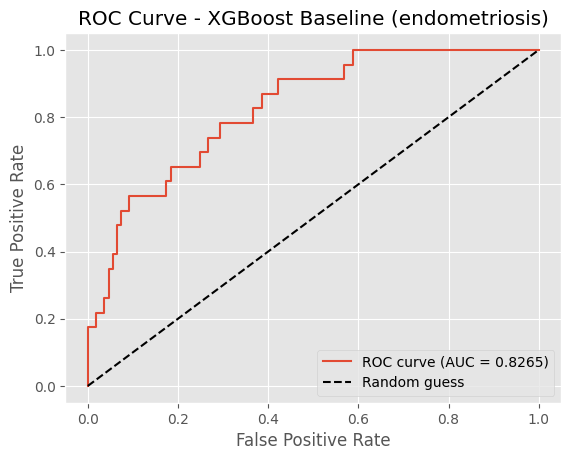

In [10]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, scale_pos_weight=4, subsample=0.6, random_state=42)

run_test(xgb_model, "XGBoost Baseline (endometriosis)", X_trainval, y_trainval, X_test, y_test)


### ECM

In [3]:
from EnderClassifierModified import EnderClassifier as ECM

param_grid = {
    'n_rules': [i for i in range(1, 40)],
    'use_gradient': [True, False],
    'nu': [0.9, 0.95, 0.99, 1.0],
    'sampling': [0.4, 0.6, 0.8, 0.9, 1.0],
    'verbose': [False]
}

grid_search_m = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m.best_params_)
print("Best cross-val F1:", grid_search_m.best_score_)

best_model = grid_search_m.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 36, 'nu': 0.99, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}
Best cross-val F1: 0.45606462524045294

Test set evaluation:
              precision    recall  f1-score   support

           0     0.8655    0.9450    0.9035       109
           1     0.5385    0.3043    0.3889        23

    accuracy                         0.8333       132
   macro avg     0.7020    0.6247    0.6462       132
weighted avg     0.8086    0.8333    0.8138       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             103                 6                     # True Negative (TN), False Positive (FP)
Class 1             16                  7                     # False Negative (FN), True Positive (TP)


In [4]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_m.cv_results_['mean_test_score'])), key=lambda i: grid_search_m.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_m.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_m.cv_results_['mean_test_score'][i]}, Params: {grid_search_m.cv_results_['params'][i]}")
    print("=====================================================")

# save the top 20 parameters into a file in json format
import json
with open('top_20_params_ecm_2608.json', 'w') as f:
    json.dump(top_20_params, f, indent=4)
# save the scores in a file as well
with open('top_20_scores_ecm_2608.json', 'w') as f:
    json.dump([grid_search_m.cv_results_['mean_test_score'][i] for i in top_20_indices], f, indent=4)

[1422, 1035, 1091, 820, 1302, 672, 615, 862, 1484, 1462, 385, 1145, 1001, 1471, 504, 710, 1442, 1037, 544, 1343]
[{'n_rules': 36, 'nu': 0.99, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'n_rules': 26, 'nu': 1.0, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}, {'n_rules': 28, 'nu': 0.95, 'sampling': 0.4, 'use_gradient': False, 'verbose': False}, {'n_rules': 21, 'nu': 0.99, 'sampling': 0.4, 'use_gradient': True, 'verbose': False}, {'n_rules': 33, 'nu': 0.99, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'n_rules': 17, 'nu': 1.0, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'n_rules': 16, 'nu': 0.95, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}, {'n_rules': 22, 'nu': 0.99, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'n_rules': 38, 'nu': 0.9, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 37, 'nu': 0.99, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'n_rules': 10, 'nu': 0.99

ECM Model (endometriosis)
Accuracy: 0.84091
ROC AUC: 0.76426
F1 Score: 0.46154
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.8793    0.9358    0.9067       109
           1     0.5625    0.3913    0.4615        23

    accuracy                         0.8409       132
   macro avg     0.7209    0.6635    0.6841       132
weighted avg     0.8241    0.8409    0.8291       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             102                 7                     # True Negative (TN), False Positive (FP)
Class 1             14                  9                     # False Negative (FN), True Positive (TP)


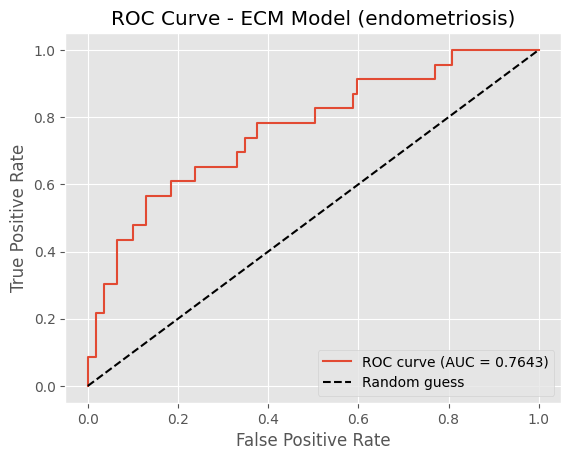

In [23]:
from EnderClassifierModified import EnderClassifier as ECM

ecm_model = ECM(n_rules=36, nu=0.99, sampling=0.6, use_gradient=True, verbose=False, random_state=42)
run_test(ecm_model, "ECM Model (endometriosis)", X_trainval, y_trainval, X_test, y_test)

### ECBF

In [5]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

param_grid = {
    'n_rules': [i for i in range(24, 44)],
    'use_gradient': [True, False],
    'nu': [0.9, 0.95, 0.99, 1.0],
    'sampling': [0.4, 0.6, 0.8, 0.9, 1.0],
    'verbose': [False],
    'max_clusters': [i for i in range(1, 6)],
    'lambda_reg': [0.0, 0.1, 0.24, 0.5, 0.75, 1.0]
}

grid_search_bf = GridSearchCV(
    estimator=ECBF(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_bf.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_bf.best_params_)
print("Best cross-val F1:", grid_search_bf.best_score_)

best_model = grid_search_bf.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'lambda_reg': 1.0, 'max_clusters': 2, 'n_rules': 25, 'nu': 1.0, 'sampling': 0.9, 'use_gradient': False, 'verbose': False}
Best cross-val F1: 0.49060033805443837

Test set evaluation:
              precision    recall  f1-score   support

           0     0.9123    0.9541    0.9327       109
           1     0.7222    0.5652    0.6341        23

    accuracy                         0.8864       132
   macro avg     0.8173    0.7597    0.7834       132
weighted avg     0.8792    0.8864    0.8807       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             104                 5                     # True Negative (TN), False Positive (FP)
Class 1             10                  13                    # False Negative (FN), True Positive (TP)


In [6]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_bf.cv_results_['mean_test_score'])), key=lambda i: grid_search_bf.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_bf.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_bf.cv_results_['mean_test_score'][i]}, Params: {grid_search_bf.cv_results_['params'][i]}")
    print("=====================================================")

# save the top 20 parameters into a file in json format
import json
with open('top_20_params_ecbf_2608.json', 'w') as f:
    json.dump(top_20_params, f, indent=4)
# save the scores in a file as well
with open('top_20_scores_ecbf_2608.json', 'w') as f:
    json.dump([grid_search_bf.cv_results_['mean_test_score'][i] for i in top_20_indices], f, indent=4)

[20877, 20605, 16345, 8427, 12589, 12629, 12669, 16589, 16629, 16669, 12639, 12799, 12429, 12679, 12709, 12719, 12749, 16429, 16709, 16749]
[{'lambda_reg': 1.0, 'max_clusters': 2, 'n_rules': 25, 'nu': 1.0, 'sampling': 0.9, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 1.0, 'max_clusters': 1, 'n_rules': 39, 'nu': 0.9, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.75, 'max_clusters': 1, 'n_rules': 32, 'nu': 0.99, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.24, 'max_clusters': 1, 'n_rules': 34, 'nu': 0.99, 'sampling': 0.9, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.5, 'max_clusters': 1, 'n_rules': 38, 'nu': 0.99, 'sampling': 1.0, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.5, 'max_clusters': 1, 'n_rules': 39, 'nu': 0.99, 'sampling': 1.0, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.5, 'max_clusters': 1, 'n_rules': 40, 'nu': 0.99, 'sampling': 1.0, 'use_gradient': False, 've

ECBF Model (endometriosis)
Accuracy: 0.87121
ROC AUC: 0.84603
F1 Score: 0.51429
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.8833    0.9725    0.9258       109
           1     0.7500    0.3913    0.5143        23

    accuracy                         0.8712       132
   macro avg     0.8167    0.6819    0.7200       132
weighted avg     0.8601    0.8712    0.8541       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             106                 3                     # True Negative (TN), False Positive (FP)
Class 1             14                  9                     # False Negative (FN), True Positive (TP)


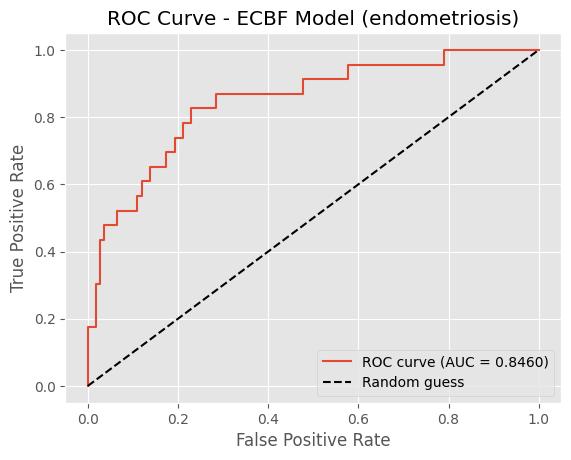

In [3]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

ecbf_model = ECBF(n_rules=39, nu=0.9, sampling=0.8, use_gradient=False, verbose=False, lambda_reg=1.0, max_clusters=2, random_state=42)

run_test(ecbf_model, "ECBF Model (endometriosis)", X_trainval, y_trainval, X_test, y_test)

ECBF Model (endometriosis)
Accuracy: 0.87879
ROC AUC: 0.83526
F1 Score: 0.55556
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.8908    0.9725    0.9298       109
           1     0.7692    0.4348    0.5556        23

    accuracy                         0.8788       132
   macro avg     0.8300    0.7036    0.7427       132
weighted avg     0.8696    0.8788    0.8646       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             106                 3                     # True Negative (TN), False Positive (FP)
Class 1             13                  10                    # False Negative (FN), True Positive (TP)


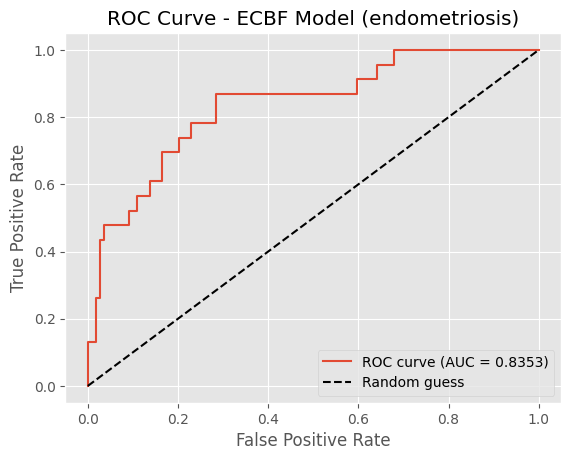

In [ ]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

ecbf_model = ECBF(n_rules=39, nu=0.9, sampling=0.8, use_gradient=False, verbose=False, lambda_reg=1.0, max_clusters=2, random_state=42)

run_test(ecbf_model, "ECBF Model (endometriosis)", X_trainval, y_trainval, X_test, y_test)

### Triple graph

In [ ]:
def graph_triple_test_roc(model1, model2, model3, names, title, X_trainval, y_trainval, X_test, y_test):
    colors = ["#4477AA", "#EE6677", "#228833",]
    plt.figure(figsize=(8, 6))
    for i, model in enumerate([model1, model2, model3]):
        # model.fit(X_trainval, y_trainval)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{names[i]} (AUC = {auc:.4f})', alpha=0.7, color=colors[i])
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for different models - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

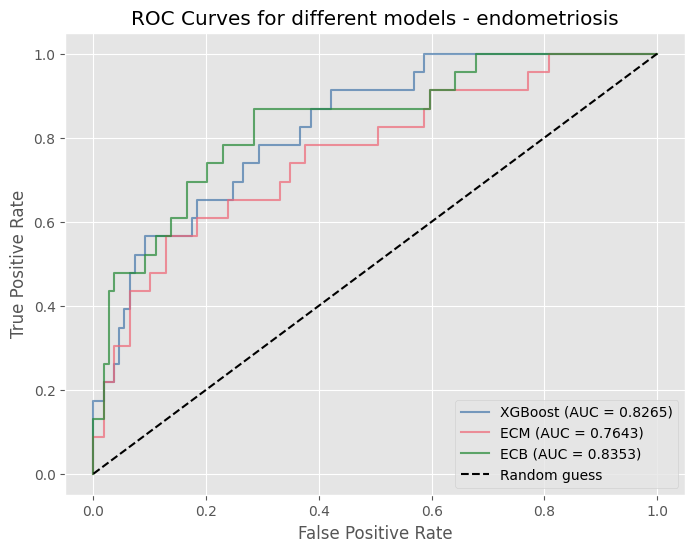

In [26]:
import xgboost as xgb
from EnderClassifierModified import EnderClassifier as ECM
from EnderClassifierBoundedFast import EnderClassifier as ECBF

xgb_model = xgb.XGBClassifier(colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, scale_pos_weight=4, subsample=0.6, random_state=42)
xgb_model.fit(X_trainval, y_trainval)
ecm_model = ECM(n_rules=36, nu=0.99, sampling=0.6, use_gradient=True, verbose=False, random_state=42)
ecm_model.fit(X_trainval, y_trainval)
ecbf_model = ECBF(n_rules=39, nu=0.9, sampling=0.8, use_gradient=False, verbose=False, lambda_reg=1.0, max_clusters=1, random_state=42)
ecbf_model.fit(X_trainval, y_trainval)

graph_triple_test_roc(
    model1 = xgb_model,
    model2 = ecm_model,
    model3 = ecbf_model,
    names = ['XGBoost', 'ECM', 'ECB'],
    title = "endometriosis",
    X_trainval = X_trainval,
    y_trainval = y_trainval,
    X_test = X_test,
    y_test = y_test
)

### Rule analysis

In [2]:
from EnderClassifierModified import EnderClassifier as ECM

ecm_model = ECM(n_rules=36, nu=0.99, sampling=0.6, use_gradient=True, verbose=False, random_state=42)
ecm_model.fit(X_trainval, y_trainval)

print(f"Default decision: {ecm_model.default_rule[0]}, {ecm_model.default_rule[1]}")
print("=============================================")
for i, rule in enumerate(ecm_model.rules):
    print(f"Rule {i}:")
    for condition in rule.conditions:
        print(f"\t{ecm_model.attribute_names[condition[0]]}: ({condition[1] if condition[1] != -1e308 else '-inf'}, {condition[2] if condition[2] != 1e308 else 'inf'})")
    print(f"    Decision: {rule.decision[0]}, {rule.decision[1]}")
    print("=============================================")

Default decision: 0.6261960820213658, -0.6261960820213658
Rule 0:
	sex_pain_level: (-inf, 4.5)
	cycle: (22.0, inf)
	defecation_pain_during: (-0.5, inf)
	menstruation_pain: (-inf, 9.5)
	chronic_pain_level: (-inf, 7.5)
	height: (-inf, 179.0)
	regular_cycle: (-0.5, inf)
	alcohol_units: (-inf, 9.0)
    Decision: 0.5742079720553936, -0.5742079720553936
Rule 1:
	pain_level: (1.25, inf)
	age: (25.5, 76.5)
	cycle: (3.5, 34.5)
	weight: (49.0, 112.0)
	first_menstruation: (8.0, inf)
	menstruation_length: (2.5, inf)
	bloody_urine_apart: (-inf, 0.5)
	vomit_during: (-0.5, inf)
	smoking_time: (-inf, 28.5)
	birth_weight: (1900.0, inf)
	pregnancy: (-inf, 7.0)
	nausea_during: (-0.5, inf)
	nausea_apart: (-0.5, inf)
    Decision: -0.3294035370186199, 0.3294035370186199
Rule 2:
	sex_pain: (0.5, inf)
	chronic_pain_level: (0.5, inf)
	pain_level: (1.25, inf)
	age: (23.5, 53.5)
	pregnancy: (-inf, 2.5)
	birth_weight: (2640.0, inf)
	toparm_pain_apart: (-0.5, inf)
	defecation_blood_during: (-0.5, inf)
	menstruati

In [4]:
ecm_model.evaluate_all_rules()
print(ecm_model.history)

100%|██████████| 36/36 [00:00<00:00, 283.73it/s]

{'accuracy': [0.8247978436657682, 0.8247978436657682, 0.8247978436657682, 0.8544474393530997, 0.8557951482479784, 0.8706199460916442, 0.8733153638814016, 0.8881401617250674, 0.8881401617250674, 0.8921832884097035, 0.894878706199461, 0.9070080862533693, 0.9123989218328841, 0.9204851752021563, 0.9137466307277629, 0.9245283018867925, 0.9258760107816711, 0.9326145552560647, 0.9366576819407008, 0.9366576819407008, 0.9460916442048517, 0.9433962264150944, 0.9474393530997305, 0.9501347708894878, 0.9555256064690026, 0.9514824797843666, 0.9528301886792453, 0.9595687331536388, 0.9609164420485176, 0.9568733153638814, 0.9568733153638814, 0.9609164420485176, 0.967654986522911, 0.9649595687331537, 0.9663072776280324, 0.967654986522911, 0.9757412398921833], 'mean_absolute_error': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], '

In [4]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

ecbf_model = ECBF(n_rules=39, nu=0.9, sampling=0.8, use_gradient=False, verbose=False, lambda_reg=1.0, max_clusters=2, random_state=42)
ecbf_model.fit(X_trainval, y_trainval)

print(f"Default decision: {ecbf_model.default_rule[0]}, {ecbf_model.default_rule[1]}")
print("=============================================")
for i, rule in enumerate(ecbf_model.rules):
    print(f"Rule {i}:")
    for condition in rule.conditions:
        print(f"\t{ecbf_model.attribute_names[condition[0]]}: ({condition[1] if condition[1] != -1e308 else '-inf'}, {condition[2] if condition[2] != 1e308 else 'inf'})")
    print(f"    Decision: {rule.decision[0]}, {rule.decision[1]}")
    print("=============================================")

Default decision: 0.5692691654739689, -0.5692691654739689
Rule 0:
	pain_level: (-inf, 1.25)
	defecation_pain_during: (-inf, 0.5)
	hormonal_birthcontrol: (-0.5, inf)
	chronic_pain_level: (-inf, 8.0)
	weight: (-inf, 114.5)
	cycle: (-inf, 45.0)
	height: (-inf, 179.0)
	alcohol_units: (-inf, 9.2)
    Decision: 0.5947631548316178, -0.5947631548316178
Rule 1:
	sex_pain_level: (-inf, 3.5)
    Decision: 0.2576376094341046, -0.2576376094341046
Rule 2:
	pelvis_pain_apart: (0.5, inf)
	age: (23.5, inf)
	defecation_pain_during: (0.5, inf)
	weight: (51.0, inf)
	menstruation_length: (2.5, 10.0)
	height: (156.5, inf)
	menstruation_pain: (2.5, inf)
	stomach_cramps_apart: (-0.5, inf)
    Decision: -0.8792370233076822, 0.8792370233076822
Rule 3:
	infertility: (0.5, inf)
    Decision: -0.33683578875050224, 0.33683578875050224
Rule 4:
	menstruation_pain: (-inf, 6.5)
    Decision: 0.15852905750774982, -0.15852905750774982
Rule 5:
	family_endo: (0.5, inf)
    Decision: -0.27550027466823496, 0.2755002746682349

In [20]:
# number of rules fired for each instance in the test set
def count_rules_fired(model, X):
    rules_fired_counts = []
    for _, row in X.iterrows():
        count = 0
        for rule in model.rules:
            not_matched = False
            for condition in rule.conditions:
                if not (condition[1] <= row[model.attribute_names[condition[0]]] <= condition[2]):
                    not_matched = True
                    break
            if not not_matched:
                count += 1
        rules_fired_counts.append(count)
    return rules_fired_counts

ecm_rules_fired = count_rules_fired(ecm_model, X_trainval)
ecbf_rules_fired = count_rules_fired(ecbf_model, X_trainval)

In [21]:
print(f"ECM - Average number of rules fired: {np.mean(ecm_rules_fired):.2f}, Max: {np.max(ecm_rules_fired)}, Min: {np.min(ecm_rules_fired)}")
print(f"ECBF - Average number of rules fired: {np.mean(ecbf_rules_fired):.2f}, Max: {np.max(ecbf_rules_fired)}, Min: {np.min(ecbf_rules_fired)}")

ECM - Average number of rules fired: 11.67, Max: 26, Min: 0
ECBF - Average number of rules fired: 12.93, Max: 21, Min: 4


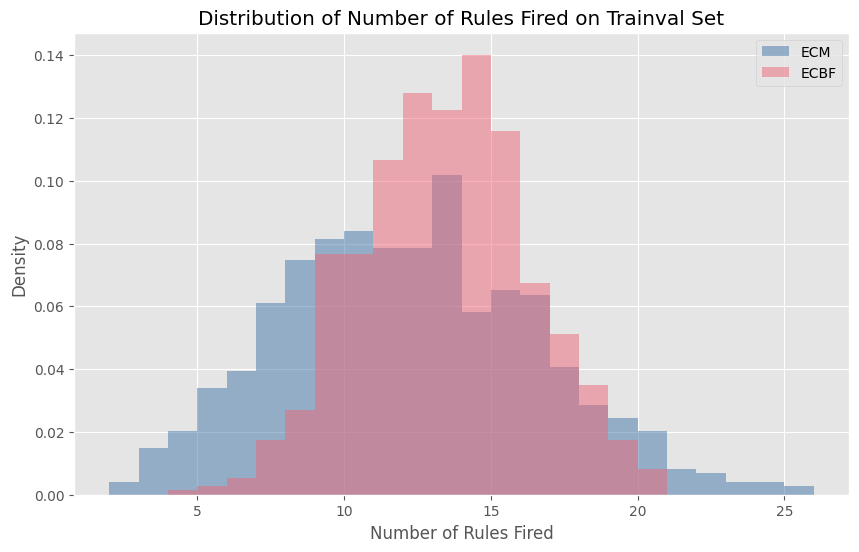

In [22]:
# plot the distribution of rules fired for both models
plt.figure(figsize=(10, 6))
plt.hist(ecm_rules_fired, bins=range(2, max(ecm_rules_fired)+1), alpha=0.5, label='ECM', color='#4477AA', density=True)
plt.hist(ecbf_rules_fired, bins=range(2, max(ecbf_rules_fired)+1), alpha=0.5, label='ECBF', color='#EE6677', density=True)
plt.xlabel('Number of Rules Fired')
plt.ylabel('Density')
plt.title('Distribution of Number of Rules Fired on Trainval Set')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
ecbf_rule_lengths = []
ecbf_rule_weights = []
for i, rule in enumerate(ecbf_model.rules):
    ecbf_rule_lengths.append(len(rule.conditions))
    ecbf_rule_weights.append(rule.decision[1])

ecm_rule_lengths = []
ecm_rule_weights = []
for i, rule in enumerate(ecm_model.rules):
    ecm_rule_lengths.append(len(rule.conditions))
    ecm_rule_weights.append(rule.decision[1])

In [6]:
print(ecm_rule_lengths)
print(ecbf_rule_lengths)

[8, 13, 13, 14, 17, 8, 10, 14, 13, 14, 17, 9, 20, 11, 16, 9, 24, 13, 9, 25, 13, 17, 8, 18, 17, 18, 13, 9, 11, 11, 15, 18, 10, 30, 8, 30]
[8, 1, 8, 1, 1, 1, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


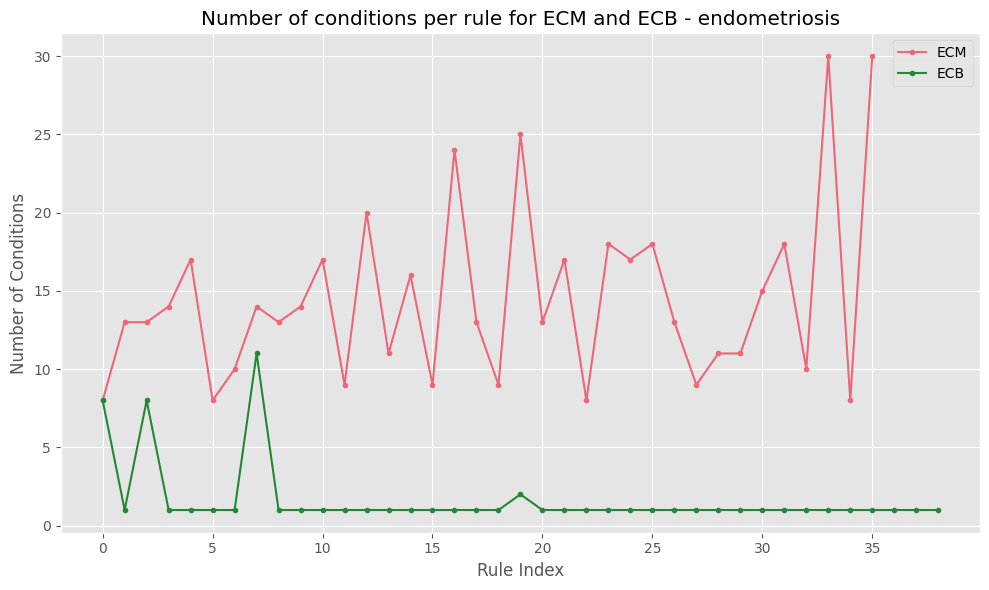

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(ecm_rule_lengths, label='ECM', color="#EE6677", marker=".")
ax.plot(ecbf_rule_lengths, label='ECB', color="#228833", marker=".")
ax.set_title("Number of conditions per rule for ECM and ECB - endometriosis")
ax.legend()
ax.set_xlabel('Rule Index')
ax.set_ylabel('Number of Conditions')
ax.grid(True)
fig.tight_layout()

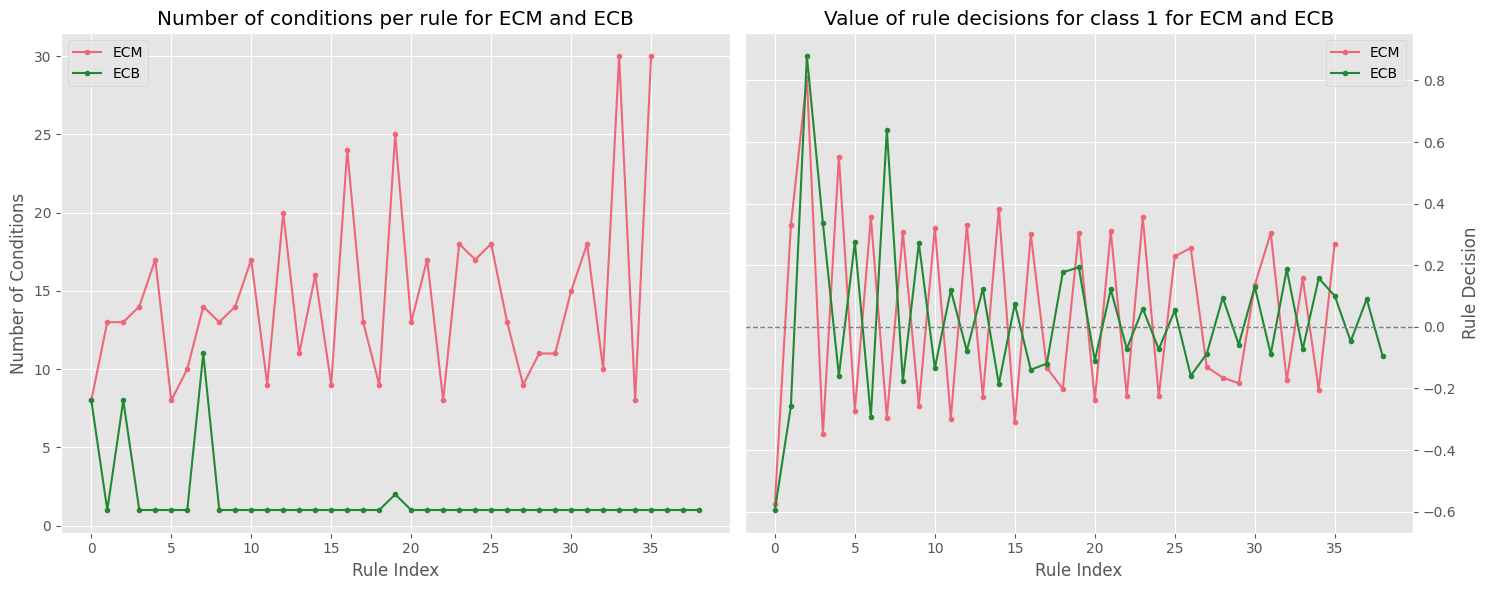

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(ecm_rule_lengths, label='ECM', color="#EE6677", marker=".")
ax[1].plot(ecm_rule_weights, label='ECM', color="#EE6677", marker=".")
ax[0].plot(ecbf_rule_lengths, label='ECB', color="#228833", marker=".")
ax[1].plot(ecbf_rule_weights, label='ECB', color="#228833", marker=".")
ax[1].axhline(0, color='gray', linestyle='--', linewidth=1)
ax[0].set_title("Number of conditions per rule for ECM and ECB")
ax[1].set_title("Value of rule decisions for class 1 for ECM and ECB")
ax[0].legend()
ax[1].legend()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[0].set_xlabel('Rule Index')
ax[1].set_xlabel('Rule Index')
ax[0].set_ylabel('Number of Conditions')
ax[1].set_ylabel('Rule Decision')
ax[0].grid(True)
fig.tight_layout()